# Ensemble

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
from xgboost import plot_importance
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso,Ridge
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

pd.set_option('display.max_columns', None) # no truncate columns

In [2]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "preprocessing"
with open(data_path_out + 'train_pp.obj', 'rb') as file:
    train = pickle.load(file)
with open(data_path_out + 'test_pp.obj', 'rb') as file:
    test = pickle.load(file)

In [3]:
print(train.shape)
train.head()

(523021, 77)


,StoreID,Date,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,Hol_and_open,Region_PD,stores_per_region,stores_per_person,stores_per_KM2,GDP_per_capita,real_feel,week_of_month,year,quarter,month,day_of_month,day_of_week,day_of_year,WeekOfYear,days_in_month,Events_Hail,Region_0,Region_1,Region_10,Region_2,Region_3,Region_4,Region_5,Region_7,Region_9,Region_6,Region_8,AssortmentType_General,AssortmentType_With Non-Food Department,AssortmentType_With Fish Department,StoreType_Hyper Market,StoreType_Standard Market,StoreType_Super Market,StoreType_Shopping Center,Events_Fog,Events_Rain,Events_Snow,Events_Thunderstorm,Events_Normal,Region,HolidaysWeekBefore,HolidaysWeekCurrent,HolidaysWeekAfter,PromoWeekBefore,PromoWeekCurrent,PromoWeekAfter,NumberOfSales
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1000,2016-03-01,False,True,False,326,9643,17130,2770,8.0,1,100,1032,2,19.0,21,-1,82,1030,1,11.0,16,-2,70,1029,1,6.0,0.0,23,False,0.287255,62,0.022383,0.00643,0.006184,32.788038,0,2016,1,3,1,1,61,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7,0,0,0,0,0,5,5676
1,1000,2016-03-02,False,True,False,326,9643,17130,2770,8.0,0,87,1030,5,23.0,16,-1,73,1027,3,13.0,10,-2,58,1025,1,10.0,0.0,56,False,0.287255,62,0.022383,0.00643,0.006184,36.601140,0,2016,1,3,2,2,62,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,7,0,0,0,0,0,5,8111
2,1000,2016-03-04,False,True,False,326,9643,17130,2770,8.0,0,81,1026,4,31.0,23,-1,71,1024,3,11.0,10,-3,55,1023,2,8.0,0.0,22,False,0.287255,62,0.022383,0.00643,0.006184,36.602307,0,2016,1,3,4,4,64,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,7,0,0,0,0,0,5,8300
3,1000,2016-03-05,False,True,False,326,9643,17130,2770,6.0,-3,80,1027,8,31.0,19,-4,56,1024,3,15.0,10,-6,25,1022,-1,10.0,0.0,108,False,0.287255,62,0.022383,0.00643,0.006184,36.602307,0,2016,1,3,5,5,65,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,7,0,0,0,0,0,5,7154
4,1000,2016-03-06,False,False,False,326,9643,17130,2770,6.0,0,93,1025,7,31.0,16,-3,75,1023,1,12.0,5,-6,48,1022,-5,5.0,0.0,46,False,0.287255,62,0.022383,0.00643,0.006184,33.236222,0,2016,1,3,6,6,66,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,7,0,0,0,0,0,5,0


## Utilities

In [4]:
# categorized feature lists to ease the preprocessing
filter_startswith = lambda l,s: [x for x in l if x.startswith(s)]

# regional features
r_regions = ['Region_'+str(i) for i in range(11)]
r_assortments = filter_startswith(train.columns, 'AssortmentType_')
r_storetype = filter_startswith(train.columns, 'StoreType_')
r_general = ['NearestCompetitor', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'Region_PD',
             'stores_per_region', 'stores_per_person', 'stores_per_KM2', 'GDP_per_capita']
regional_features =  r_regions + r_assortments + r_storetype + r_general

# meteo features
m_events = filter_startswith(train.columns, 'Events_')
m_general = ['CloudCover', 'Max_Dew_PointC', 'Max_Humidity', 'Max_Sea_Level_PressurehPa',
             'Max_TemperatureC', 'Max_VisibilityKm', 'Max_Wind_SpeedKm_h',
             'Mean_Dew_PointC', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa',
             'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h',
             'Min_Dew_PointC', 'Min_Humidity', 'Min_Sea_Level_PressurehPa',
             'Min_TemperatureC', 'Min_VisibilitykM', 'Precipitationmm',
             'WindDirDegrees', 'real_feel']
meteo_features =  m_events + m_general

# store features
store_features = ['IsHoliday', 'IsOpen', 'HasPromotions', 'Hol_and_open']

# seasonal features
seasonal_features = ['week_of_month', 'year', 'quarter', 'month', 'day_of_month',
                     'day_of_week', 'day_of_year', 'WeekOfYear', 'days_in_month',
                     'HolidaysWeekBefore', 'HolidaysWeekCurrent','HolidaysWeekAfter',
                     'PromoWeekBefore', 'PromoWeekCurrent', 'PromoWeekAfter']

# x and y specific
x_features = ['StoreID']
y_features = ['NumberOfSales']

In [5]:
# split train set in x and y
def split_dataset(dataset):
    x = dataset.drop('NumberOfSales', axis=1)
    y = dataset.NumberOfSales
    
    return (x, y)

# split train set by months
def split_dataset_bymonth(test_year, test_months, train_set):
    test_mask = (train_set.year == test_year) & train_set.month.isin(test_months)

    # define the train set
    train_dataset = train_set[~test_mask]
    x_train, y_train = split_dataset(train_dataset)
    
    # define the test set
    test_dataset = train_set[test_mask]
    x_test, y_test = split_dataset(test_dataset)
    
    return (x_train, y_train, x_test, y_test)

In [6]:
# set to 0 the NumberOfSales of closed stores
def nos_correction(dataset, results):
    dataset['results'] = results
    
    mask_close = (dataset.IsOpen == False)
    
    dataset.loc[mask_close, 'results'] = 0
    
    return dataset['results']

In [7]:
# reorder results monthly wrt regions, stores pairing predictions with actual values
def get_regional_results(results, x, y=0):
    # create the dataframe and round predicted values to int
    df_results = x[['StoreID', 'month'] + r_regions].copy()
    df_results['predicted'] = results.astype(int)
    
    # create 'actual' values column if passed
    if isinstance(y, int):
        agg_dict = {'predicted': 'sum'}
    else:
        agg_dict = {'predicted': 'sum', 'actual': 'sum'}
        df_results['actual'] = y.astype(int)
    
    # aggregate prediction monthly
    df_results = df_results.groupby(['StoreID', 'month']+r_regions)\
    .agg(agg_dict).reset_index()
    
    # reverse region one-hot-encoding
    df_results['region'] = df_results[r_regions].idxmax(axis=1)\
    .map(lambda x: str(x).replace('Region_', ''))
    df_results = df_results.drop(r_regions, axis=1)
    
    df_results = df_results.sort_values(by=['region', 'StoreID', 'month'])\
    .reset_index().drop('index', axis=1)    
    
    return df_results

# format format suitable for the submission of the project
def get_submission_format(regional_results):
    submit_results = regional_results.copy()
    
    # drop region column and reorder wrt storeid and month
    submit_results = submit_results.drop('region', axis=1)\
    .sort_values(by=['StoreID', 'month'])\
    .reset_index().drop('index', axis=1)
    
    return submit_results

In [8]:
# get stores by region df
def get_stores_byRegion(df):
    df = df[['StoreID'] + r_regions].drop_duplicates().set_index('StoreID')
    
    df['Region'] = df[r_regions].idxmax(axis=1)\
    .map(lambda x: str(x).replace('Region_', ''))
    
    return df.drop(r_regions, axis=1)

df_store_byRegion = get_stores_byRegion(train)

# reorder results monthly wrt regions, stores pairing predictions with actual values
def get_store_results(storeid, results, x, y=0):
    # create the dataframe and round predicted values to int
    df_results = x[['StoreID', 'month']].copy()
    df_results['predicted'] = results.astype(int)
    df_results['region'] = df_store_byRegion[df_store_byRegion.index == storeid].Region.values[0]
    
    # create 'actual' values column if passed
    if isinstance(y, int):
        agg_dict = {'predicted': 'sum'}
    else:
        agg_dict = {'predicted': 'sum', 'actual': 'sum'}
        df_results['actual'] = y.astype(int)
    
    # aggregate prediction monthly
    df_results = df_results.groupby(['StoreID', 'month', 'region'])\
    .agg(agg_dict).reset_index()
    
    df_results = df_results.sort_values(by=['region', 'StoreID', 'month'])\
    .reset_index().drop('index', axis=1)    
    
    return df_results

In [9]:
# Lanzi error

# Regional error
# DataFrame: 'StoreID' 'month' 'predicted' 'actual' 'region'
def lanzi_region_error(region):
    num = region[['actual', 'predicted']].apply(lambda x: abs(x[0] - x[1]), axis=1).sum()
    den = region['actual'].sum()
    
    return num/den
    
# Total error across all regions
# region_errors = [0.3, 0.5, ... ]
def lanzi_total_error(region_errors):
    return sum(region_errors)/len(region_errors)

def lanzi_error(regional_results):
    region_errors = []
    for regionid, region in regional_results.groupby('region'):
        region_errors.append(lanzi_region_error(region))
    
    return (region_errors, lanzi_total_error(region_errors))

# Print results of Lanzi error
def lanzi_print(r_error, t_error):
    print('LANZI ERROR')
    print('-' * 20) 
    print('{:<10}{:>10}'.format('REGION', 'ERROR'))
    
    for regionid, error in enumerate(r_error):
        print('{:<10}{:>10.4f}'.format(regionid, error))
    print('-' * 20)
    print('{:<10}{:>10.4f}'.format('TOTAL', t_error))

In [10]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

## Preprocessing

In [11]:
# Robust Scaler
rs = RobustScaler()

features_to_scale = r_general + m_general

train[features_to_scale] = rs.fit_transform(train[features_to_scale])
test[features_to_scale] = rs.fit_transform(test[features_to_scale])

In [12]:
# drop useless features
m_general.remove('real_feel')

features_to_drop = ['Region', 'Date'] + m_general

train = train.drop(labels=features_to_drop, axis=1)
test = test.drop(labels=features_to_drop, axis=1)

## Train and predict

In [13]:
# models settings
xgboost_general_params = {
    'max_depth': 12,
    'learning_rate': 0.2,
    'n_jobs': 4,
    'silent': False
}

xgboost_params = {
    'n_estimators': 100
}

lasso_params = {
    'alpha': 20
}

gradientboosting_params = {
    'n_estimators': 50,
    'max_depth': 5,
    'learning_rate': 0.07,
    'loss': 'huber',
    'random_state': 5
}

extratrees_params = {
    'n_estimators': 50
}

kfold_params = {
    'n_splits': 2,
    'shuffle': True,
    'random_state': 42
}

# months to predict
year = 2018
months = [1, 2]

In [14]:
# general model
x_train, y_train, x_test, y_test =\
    split_dataset_bymonth(year, months, train)

general_model = XGBRegressor(**xgboost_general_params)
general_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [15]:
# single models
single_model_1 = Lasso(**lasso_params)
single_model_2 = XGBRegressor(**xgboost_params)
single_model_3 = GradientBoostingRegressor(**gradientboosting_params)
single_model_4 = ExtraTreesRegressor(**extratrees_params)

single_model = AveragingModels(models=(single_model_1, single_model_2,
                                       single_model_3, single_model_4))

In [16]:
scores = {}
results = pd.DataFrame()

single_store_train = train.drop(regional_features, axis=1)

for storeid, store in single_store_train.groupby('StoreID'):    
    # split the dataset
    s_x_train, s_y_train, s_x_test, s_y_test =\
    split_dataset_bymonth(year, months, store)
    g_x_train, g_y_train, g_x_test, g_y_test =\
    split_dataset_bymonth(year, months, train[train.StoreID == storeid])
    
    # train the single model on the given store
    single_model.fit(s_x_train, s_y_train)
    
    # make prediction on the given store
    s_predicted = single_model.predict(s_x_test)
    g_predicted = general_model.predict(g_x_test)
    
    s_predicted = nos_correction(s_x_test, s_predicted) 
    g_predicted = nos_correction(g_x_test, g_predicted)
    
    # average single with general model
    predicted = pd.concat([s_predicted, g_predicted], axis=1).mean(axis=1)

    # scores
    scores[storeid] = r2_score(s_y_test, predicted)
    print('store {} r2 -> {:.4f}'.format(storeid, scores[storeid]))
    
    # store results
    results = pd.concat([results, get_store_results(storeid, predicted, s_x_test, s_y_test)])

store 1000 r2 -> 0.9182
store 1001 r2 -> 0.6318
store 1002 r2 -> 0.9635
store 1003 r2 -> 0.9459
store 1004 r2 -> 0.9270
store 1005 r2 -> 0.9180
store 1006 r2 -> 0.9012
store 1007 r2 -> 0.9509
store 1008 r2 -> 0.1839
store 1009 r2 -> 0.9586
store 1010 r2 -> 0.9049
store 1011 r2 -> 0.8072
store 1012 r2 -> 0.9556
store 1013 r2 -> 0.9713
store 1014 r2 -> 0.8821
store 1015 r2 -> 0.9233
store 1016 r2 -> 0.8588
store 1017 r2 -> 0.9663
store 1018 r2 -> 0.9405
store 1019 r2 -> 0.9584
store 1020 r2 -> 0.9411
store 1021 r2 -> 0.9617
store 1022 r2 -> 0.9756
store 1023 r2 -> 0.9037
store 1024 r2 -> 0.9691
store 1025 r2 -> 0.9140
store 1026 r2 -> 0.9586
store 1027 r2 -> 0.9445
store 1028 r2 -> 0.8735
store 1029 r2 -> 0.8994
store 1030 r2 -> 0.9376
store 1031 r2 -> 0.8970
store 1032 r2 -> 0.9306
store 1033 r2 -> 0.9648
store 1034 r2 -> 0.9346
store 1035 r2 -> 0.9466
store 1036 r2 -> 0.9393
store 1037 r2 -> 0.6138
store 1038 r2 -> 0.9701
store 1039 r2 -> 0.9679
store 1040 r2 -> 0.9521
store 1041 r2 ->

store 1342 r2 -> 0.9579
store 1343 r2 -> 0.9301
store 1344 r2 -> 0.9363
store 1345 r2 -> 0.3319
store 1346 r2 -> -0.4831
store 1347 r2 -> 0.9638
store 1348 r2 -> 0.9285
store 1349 r2 -> 0.5718
store 1350 r2 -> 0.9414
store 1351 r2 -> 0.8986
store 1352 r2 -> 0.8441
store 1353 r2 -> 0.8558
store 1354 r2 -> 0.9774
store 1355 r2 -> 0.9141
store 1356 r2 -> 0.9291
store 1357 r2 -> 0.8343
store 1358 r2 -> 0.9563
store 1359 r2 -> 0.9003
store 1360 r2 -> 0.8967
store 1361 r2 -> 0.9684
store 1362 r2 -> 0.9612
store 1363 r2 -> 0.9642
store 1364 r2 -> 0.9057
store 1365 r2 -> 0.9299
store 1366 r2 -> 0.9436
store 1367 r2 -> 0.6239
store 1368 r2 -> 0.8726
store 1369 r2 -> 0.9377
store 1370 r2 -> 0.7908
store 1371 r2 -> 0.6694
store 1372 r2 -> 0.8870
store 1373 r2 -> 0.9511
store 1374 r2 -> 0.9387
store 1375 r2 -> 0.9273
store 1376 r2 -> 0.9636
store 1377 r2 -> 0.9727
store 1378 r2 -> 0.9484
store 1379 r2 -> 0.8933
store 1380 r2 -> 0.9203
store 1381 r2 -> 0.9299
store 1382 r2 -> 0.9496
store 1383 r2 -

store 1684 r2 -> 0.9716
store 1685 r2 -> 0.8915
store 1686 r2 -> 0.9484
store 1687 r2 -> 0.9590
store 1688 r2 -> 0.9323
store 1689 r2 -> 0.9647
store 1690 r2 -> 0.8995
store 1691 r2 -> 0.8987
store 1692 r2 -> 0.7844
store 1693 r2 -> 0.8513
store 1694 r2 -> 0.9795
store 1695 r2 -> 0.9672
store 1696 r2 -> 0.9642
store 1697 r2 -> 0.9340
store 1698 r2 -> 0.9582
store 1699 r2 -> 0.9640
store 1700 r2 -> 0.9208
store 1701 r2 -> 0.9478
store 1702 r2 -> 0.9824
store 1703 r2 -> 0.9750
store 1704 r2 -> 0.8746
store 1705 r2 -> 0.9611
store 1706 r2 -> 0.9646
store 1707 r2 -> 0.9616
store 1708 r2 -> 0.9599
store 1709 r2 -> 0.8937
store 1710 r2 -> 0.9717
store 1711 r2 -> 0.7346
store 1712 r2 -> 0.9282
store 1713 r2 -> 0.9730
store 1714 r2 -> 0.9475
store 1715 r2 -> 0.9646
store 1716 r2 -> 0.8300
store 1717 r2 -> 0.8839
store 1718 r2 -> 0.8828
store 1719 r2 -> 0.9588
store 1720 r2 -> 0.8976
store 1721 r2 -> 0.9558
store 1722 r2 -> 0.9120
store 1723 r2 -> 0.8920
store 1724 r2 -> 0.9017
store 1725 r2 ->

## Score

In [17]:
# average of the r2 score
print('r2 score averaged: {:.4f}'.format(sum(scores.values()) / float(len(scores.values()))))

# get lanzi error and print results
r_error, t_error = lanzi_error(results)
lanzi_print(r_error, t_error)

r2 score averaged: 0.9050
LANZI ERROR
--------------------
REGION         ERROR
0             0.0431
1             0.0425
2             0.0319
3             0.0639
4             0.0406
5             0.0386
6             0.0320
7             0.0419
8             0.0651
9             0.0551
10            0.0637
--------------------
TOTAL         0.0471


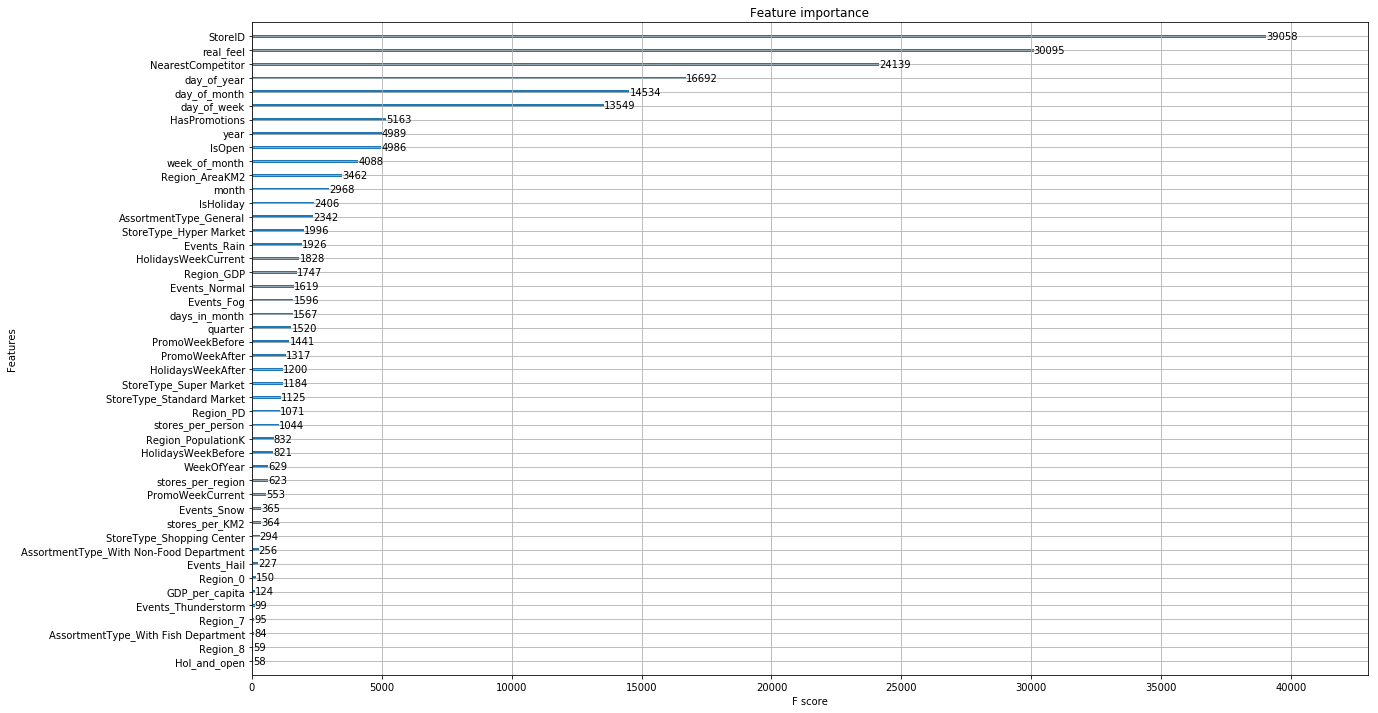

In [18]:
# Feature importance plot for the general model
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plot_importance(general_model, ax=ax)
plt.show()

## Score submit

In [14]:
# general model
x_train, y_train = split_dataset(train)

general_model = XGBRegressor(**xgboost_general_params)
general_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [15]:
# single models
single_model_1 = Lasso(**lasso_params)
single_model_2 = XGBRegressor(**xgboost_params)
single_model_3 = GradientBoostingRegressor(**gradientboosting_params)
single_model_4 = ExtraTreesRegressor(**extratrees_params)

single_model = AveragingModels(models=(single_model_1, single_model_2,
                                       single_model_3, single_model_4))

In [16]:
test.head()

,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region_AreaKM2,Region_GDP,Region_PopulationK,Hol_and_open,Region_PD,stores_per_region,stores_per_person,stores_per_KM2,GDP_per_capita,real_feel,week_of_month,year,quarter,month,day_of_month,day_of_week,day_of_year,WeekOfYear,days_in_month,Events_Hail,Region_0,Region_1,Region_10,Region_2,Region_3,Region_4,Region_5,Region_7,Region_9,Region_6,Region_8,AssortmentType_General,AssortmentType_With Non-Food Department,AssortmentType_With Fish Department,StoreType_Hyper Market,StoreType_Standard Market,StoreType_Super Market,StoreType_Shopping Center,Events_Fog,Events_Rain,Events_Snow,Events_Thunderstorm,Events_Normal,HolidaysWeekBefore,HolidaysWeekCurrent,HolidaysWeekAfter,PromoWeekBefore,PromoWeekCurrent,PromoWeekAfter
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
523021,1000,False,True,False,-0.345984,0.0,0.487203,0.0,False,0.0,-0.428571,0.011912,-0.013044,0.116379,-0.146230,0,2018,1,3,1,3,60,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5,0,5
523022,1000,False,True,False,-0.345984,0.0,0.487203,0.0,False,0.0,-0.428571,0.011912,-0.013044,0.116379,-0.541587,0,2018,1,3,2,4,61,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5,0,5
523023,1000,False,True,False,-0.345984,0.0,0.487203,0.0,False,0.0,-0.428571,0.011912,-0.013044,0.116379,-0.760321,0,2018,1,3,3,5,62,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0,5
523024,1000,False,False,False,-0.345984,0.0,0.487203,0.0,False,0.0,-0.428571,0.011912,-0.013044,0.116379,-0.200211,0,2018,1,3,4,6,63,9,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,5,0,5
523025,1000,False,True,True,-0.345984,0.0,0.487203,0.0,False,0.0,-0.428571,0.011912,-0.013044,0.116379,-0.215192,1,2018,1,3,5,0,64,10,31,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,0


In [24]:
results = pd.DataFrame()

single_store_train = train.drop(regional_features, axis=1)
single_store_test = test.drop(regional_features, axis=1)

for storeid, store in single_store_train.groupby('StoreID'):
    print(storeid)
    
    # split the dataset
    s_x_train, s_y_train = split_dataset(store)
    s_x_test = single_store_test[single_store_test.StoreID == storeid].copy()
    g_x_test = test[test.StoreID == storeid].copy()
    
    # train the single model on the given store
    single_model.fit(s_x_train, s_y_train)
    
    # make prediction on the given store
    s_predicted = single_model.predict(s_x_test)
    g_predicted = general_model.predict(g_x_test)
    
    s_predicted = nos_correction(s_x_test, s_predicted) 
    g_predicted = nos_correction(g_x_test, g_predicted)
    
    # average single with general model
    predicted = pd.concat([s_predicted, g_predicted], axis=1).mean(axis=1)
    
    # store results
    results = pd.concat([results, get_store_results(storeid, predicted, s_x_test)])

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


In [27]:
results.head()

,StoreID,month,region,predicted
0,1000,3,7,180600
1,1000,4,7,169674
0,1001,3,0,93620
1,1001,4,0,85191
0,1002,3,3,125407


In [28]:
# get the dataframe submission format
# df_submission = get_submission_format(submit_regional_results)

print(results.shape)
results.head()

(1498, 4)


,StoreID,month,region,predicted
0,1000,3,7,180600
1,1000,4,7,169674
0,1001,3,0,93620
1,1001,4,0,85191
0,1002,3,3,125407


In [29]:
# write submission csv
results.to_csv(data_path_out+'submission.csv', index=False)